# 混淆矩阵

通过测试集所有图像预测结果，生成多类别混淆矩阵，评估模型准确度。

同济子豪兄：https://space.bilibili.com/1900783

[代码运行云GPU环境](https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1)：GPU RTX 3060、CUDA v11.2

## 进入 mmclassification 目录

In [2]:
import os
os.chdir('mmclassification')

## 设置Matplotlib中文字体

In [2]:
# # windows操作系统
# plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
# plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [3]:
# Mac操作系统，参考 https://www.ngui.cc/51cto/show-727683.html
# 下载 simhei.ttf 字体文件
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

In [1]:
# Linux操作系统，例如 云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1
# 如果遇到 SSL 相关报错，重新运行本代码块即可
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf -O /environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf
!rm -rf /home/featurize/.cache/matplotlib

import matplotlib
matplotlib.rc("font",family='SimHei') # 中文字体


--2022-08-23 09:16:26--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf
Connecting to 172.16.0.13:5848... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10050868 (9.6M) [application/x-font-ttf]
Saving to: ‘/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf’

/environment/minico 100%[===================>]   9.58M  18.4MB/s    in 0.5s    

2022-08-23 09:16:26 (18.4 MB/s) - ‘/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf’ saved [10050868/10050868]



## 导入工具包

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import math
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

## 载入类别名称和ID

In [4]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()
# 获得类别名称
classes = list(idx_to_labels.values())
print(classes)

['哈密瓜', '圣女果', '山竹', '杨梅', '柚子', '柠檬', '桂圆', '梨', '椰子', '榴莲', '火龙果', '猕猴桃', '石榴', '砂糖橘', '胡萝卜', '脐橙', '芒果', '苦瓜', '苹果-红', '苹果-青', '草莓', '荔枝', '菠萝', '葡萄-白', '葡萄-红', '西瓜', '西红柿', '车厘子', '香蕉', '黄瓜']


## 载入测试集预测结果表格

In [6]:
!ls

CITATION.cff	     imagenet_class_index.csv
CONTRIBUTING.md      labels_to_idx.npy
LICENSE		     mmcls
MANIFEST.in	     mmcls.egg-info
README.md	     model-index.yml
README_zh-CN.md      output
SimHei.ttf	     outputs
cam.jpg		     requirements
cam_images	     requirements.txt
cam_images_imagenet  resnet18_batch256_imagenet_20200708-34ab8f90.pth
checkpoints	     resources
configs		     setup.cfg
data		     setup.py
demo		     test_img
docker		     tests
docs		     testset_result.json
fruit30_split	     tools
idx_to_labels.npy    work_dirs


In [7]:
df = pd.read_csv('work_dirs/mobilenet_v2_1x_fruit30/测试集预测结果.csv')

In [8]:
df.head()

,图像路径,标注类别名称,标注类别ID,top-1-预测ID,top-1-预测名称,top-2-预测ID,top-2-预测名称,top-3-预测ID,top-3-预测名称,top-n预测正确,...,草莓-预测置信度,荔枝-预测置信度,菠萝-预测置信度,葡萄-白-预测置信度,葡萄-红-预测置信度,西瓜-预测置信度,西红柿-预测置信度,车厘子-预测置信度,香蕉-预测置信度,黄瓜-预测置信度
0,fruit30_split/val/苦瓜/161.jpg,苦瓜,17,17.0,苦瓜,14.0,胡萝卜,23.0,葡萄-白,1.0,...,0.001597,1.300516e-06,4.565059e-07,0.001999,4.944520e-04,4.040559e-05,1.985327e-04,1.293132e-07,4.450464e-07,8.378662e-05
1,fruit30_split/val/苦瓜/158.jpg,苦瓜,17,17.0,苦瓜,23.0,葡萄-白,29.0,黄瓜,1.0,...,0.000020,1.148556e-07,1.931659e-07,0.010118,1.288236e-05,3.079307e-06,3.649963e-06,1.672791e-08,7.884714e-07,2.289558e-04
2,fruit30_split/val/苦瓜/148.jpg,苦瓜,17,17.0,苦瓜,14.0,胡萝卜,29.0,黄瓜,1.0,...,0.000020,9.969936e-09,1.933638e-07,0.000011,2.079129e-07,3.513297e-05,2.743521e-07,5.043417e-10,4.636924e-07,2.881152e-04
3,fruit30_split/val/苦瓜/183.jpg,苦瓜,17,17.0,苦瓜,23.0,葡萄-白,14.0,胡萝卜,1.0,...,0.000094,1.243638e-07,3.491051e-07,0.001021,1.807617e-05,3.682075e-06,5.000793e-06,1.761318e-08,3.402481e-06,2.371633e-05
4,fruit30_split/val/苦瓜/41.jpeg,苦瓜,17,17.0,苦瓜,23.0,葡萄-白,20.0,草莓,1.0,...,0.000004,1.345433e-10,2.634503e-08,0.000514,7.998624e-08,1.178391e-09,1.978439e-08,6.912543e-13,2.308019e-08,5.676298e-07


## 生成混淆矩阵

In [9]:
from sklearn.metrics import confusion_matrix

In [10]:
confusion_matrix_model = confusion_matrix(df['标注类别名称'], df['top-1-预测名称'])

In [11]:
confusion_matrix_model.shape

(30, 30)

In [12]:
confusion_matrix_model

array([[31,  0,  0,  0,  1,  0,  0,  0,  1,  1,  0,  1,  0,  0,  1,  0,
         1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 33,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0],
       [ 0,  0, 34,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0, 33,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,
         0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0, 25,  7,  0,  0,  0,  1,  0,  2,  0,  0,  0,  0,
         0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  1, 27,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 37,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 28,  

## 可视化混淆矩阵

In [13]:
import itertools
def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))
    
    plt.title('混淆矩阵', fontsize=30)
    plt.xlabel('预测类别', fontsize=25, c='r')
    plt.ylabel('真实类别', fontsize=25, c='r')
    plt.tick_params(labelsize=16) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)
    
    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()

    plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()

In [14]:
# 查看所有配色方案
# dir(plt.cm)

In [15]:
# 子豪兄精选配色方案
# Blues
# BuGn
# Reds
# Greens
# Greys
# binary
# Oranges
# Purples
# BuPu
# GnBu
# OrRd
# RdPu

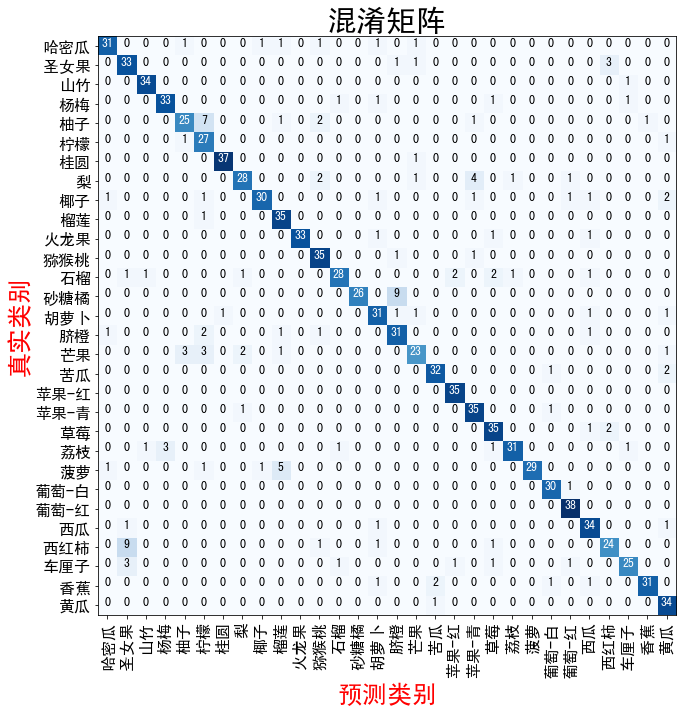

In [16]:
cnf_matrix_plotter(confusion_matrix_model, classes, cmap='Blues')

## 筛选出测试集中，真实为A类，但被误判为B类的图像

In [17]:
true_A = '荔枝'
pred_B = '杨梅'

In [18]:
wrong_df = df[(df['标注类别名称']==true_A)&(df['top-1-预测名称']==pred_B)]

In [19]:
wrong_df

,图像路径,标注类别名称,标注类别ID,top-1-预测ID,top-1-预测名称,top-2-预测ID,top-2-预测名称,top-3-预测ID,top-3-预测名称,top-n预测正确,...,草莓-预测置信度,荔枝-预测置信度,菠萝-预测置信度,葡萄-白-预测置信度,葡萄-红-预测置信度,西瓜-预测置信度,西红柿-预测置信度,车厘子-预测置信度,香蕉-预测置信度,黄瓜-预测置信度
702,fruit30_split/val/荔枝/113.jpg,荔枝,21,3.0,杨梅,21.0,荔枝,2.0,山竹,1.0,...,0.009472,0.056817,0.000003,1.833014e-06,0.010998,0.004095,0.000320,0.004255,7.674957e-06,2.789900e-05
718,fruit30_split/val/荔枝/128.jpg,荔枝,21,3.0,杨梅,21.0,荔枝,20.0,草莓,1.0,...,0.185756,0.245080,0.000004,1.392756e-05,0.006040,0.002059,0.001604,0.013187,3.951651e-06,9.728703e-04
726,fruit30_split/val/荔枝/139.jpg,荔枝,21,3.0,杨梅,20.0,草莓,21.0,荔枝,1.0,...,0.191897,0.078712,0.000001,1.231893e-09,0.000318,0.000150,0.000007,0.000115,1.946646e-09,2.388639e-07


## 可视化上表中所有被误判的图像

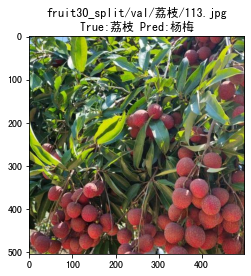

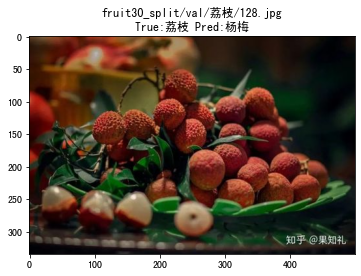

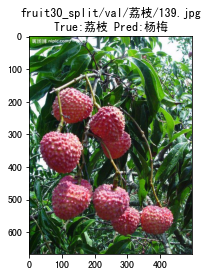

In [20]:
for idx, row in wrong_df.iterrows():
    img_path = row['图像路径']
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    title_str = img_path + '\nTrue:' + row['标注类别名称'] + ' Pred:' + row['top-1-预测名称']
    plt.title(title_str)
    plt.show()